## Initializing OpenAI

In [10]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass(
    "Enter OpenAI API Key: "
)

openai_model = "gpt-4o-mini"



In [11]:
from langchain_openai import ChatOpenAI

# For normal accurate responses
llm = ChatOpenAI(temperature=0.0, model=openai_model)

# For unique creative responses
creative_llm = ChatOpenAI(temperature=0.9, model=openai_model)

## Article sample

In [12]:
article = """
## Introduction

So, I built an AI agent. Not the Hollywood kind with sunglasses and a tragic backstory, but a local LLaMA-powered agent that can scrape the web, interpret queries, run shell commands, read files, send emails, and even peer into your clipboard like a polite digital psychic. It's built using LangChain, a Flask-based web UI, and a toolbox full of custom functions that turn this agent from a glorified chatbot into a functional command center.

The motivation behind this project was simple: I wanted something powerful, local, private, and extendable. Most AI interfaces either require cloud access or come with restrictions. I wanted mine offline, capable of handling real tasks—like summarizing documents, executing Python code, and scraping content from websites—all with a simple browser interface.

If you've ever fantasized about having your own Jarvis-lite setup without selling your data to the cloud, this build is probably your next weekend project. And yes, it can even fetch you the latest news headlines (though you'll still have to read them yourself).

## What Are AI Agents Capable Of?

As of today, AI agents have evolved well beyond conversational chatbots. They can reason through tasks, access external tools, and string together complex sequences of actions—all powered by large language models (LLMs) like GPT-4, Claude, LLaMA, and Mistral. These models serve as the brain, while agents are the nervous system that connects them to real-world inputs and actions.

Modern agents can do everything from writing code, querying databases, managing calendars, composing and sending emails, conducting research, to automating workflows across apps. Some use frameworks like LangChain or AutoGPT to plan and execute multi-step tasks. Real-world examples include:

* **AutoGPT**: An autonomous agent that can take a goal like "create a business" and iterate through planning, research, and execution.
* **AgentGPT**: A web-based playground for creating goal-driven AI agents that use APIs and web scraping.
* **MetaGPT**: Designed for software development teams, it simulates entire multi-role workflows using LLMs.

These systems often rely on tools (functions the agent can call), vector stores (to remember stuff), planners (to strategize), and even memory systems to retain state across interactions. With local models like LLaMA2 now running efficiently on personal machines, the game has changed: powerful agents no longer require the cloud.

## What This Agent Does (and How It Works)

This agent runs locally and uses the LLaMA model via `llama-cpp-python`. The LangChain framework provides the agent infrastructure, allowing it to decide when to invoke tools like scraping, file reading, or code execution. Flask handles the frontend, and the entire interface is presented through a simple web page you run locally.

Here's what the agent can currently do:

* Answer natural language queries using LLaMA
* Scrape website content using BeautifulSoup
* Read local files (TXT, JSON, etc.)
* Send emails (via SMTP)
* Execute Python code in a sandboxed environment
* Query a local SQLite database
* Fetch news (placeholder)
* Run shell commands
* Translate text
* Access clipboard content

**Good screenshot moments**:

* The Flask UI when it first loads (shows all input fields)
* A successful scrape result showing parsed website content
* Code execution result with variable outputs
* A database query returning actual table contents

## Setup Guide (Step by Step)

**1. Clone the Repo and Unzip**
Download the project ZIP and extract it to your workspace. Navigate into the `llama_agent` directory.

**2. Set Up a Virtual Environment**

```bash
python -m venv venv
source venv/bin/activate  # or venv\Scripts\activate on Windows
```

**3. Install Dependencies**

```bash
pip install -r requirements.txt
```

**4. Add a Local LLaMA Model**
Drop your `llama.gguf` or similar model file into the `model/` directory. Adjust `model_path` in `agent_core.py` accordingly.

**5. Launch the Flask App**

```bash
python run.py
```

**6. Interact via Web UI**
Go to `http://127.0.0.1:5000` and test out different tools: scrape a site, run some code, or execute a SQL query.

## Final Thoughts

This project is part tool, part playground, and part philosophical protest against data centralization. It’s proof that local AI agents can be practical, fast, and genuinely useful—even without the cloud. LangChain and LLaMA give you the core reasoning, Flask gives you the interface, and your custom tools make it actually productive.

Feel free to customize, extend, or break things. Add API keys where needed, wire it to your own services, or replace the model if you're feeling experimental. The future of AI isn't just in the cloud—it can run from your own machine, tailored exactly to your workflow.

And if it starts talking back too much? Just unplug it. It’s local.

"""

## Preparing prompts

In [13]:
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate

# Defining the system prompt (how the AI should act)
system_prompt = SystemMessagePromptTemplate.from_template(
    "You are an AI assistant that helps generate article titles."
)

# the user prompt is provided by the user, in this case however the only dynamic
# input is the article
user_prompt = HumanMessagePromptTemplate.from_template(
    """You are tasked with creating a name for a article.
The article is here for you to examine {article}

The name should be based of the context of the article.
Be creative, but make sure the names are clear, catchy,
and relevant to the theme of the article.

Only output the article name, no other explanation or
text can be provided.""",
    input_variables=["article"]
)

In [14]:
user_prompt.format(article="TEST STRING")

HumanMessage(content='You are tasked with creating a name for a article.\nThe article is here for you to examine TEST STRING\n\nThe name should be based of the context of the article.\nBe creative, but make sure the names are clear, catchy,\nand relevant to the theme of the article.\n\nOnly output the article name, no other explanation or\ntext can be provided.', additional_kwargs={}, response_metadata={})

In [15]:
from langchain.prompts import ChatPromptTemplate

first_prompt = ChatPromptTemplate.from_messages([system_prompt, user_prompt])

In [16]:
print(first_prompt.format(article="TEST STRING"))

System: You are an AI assistant that helps generate article titles.
Human: You are tasked with creating a name for a article.
The article is here for you to examine TEST STRING

The name should be based of the context of the article.
Be creative, but make sure the names are clear, catchy,
and relevant to the theme of the article.

Only output the article name, no other explanation or
text can be provided.


In [17]:
chain_one = (
    {"article": lambda x: x["article"]}
    | first_prompt
    | creative_llm
    | {"article_title": lambda x: x.content}
)

In [18]:
article_title_msg = chain_one.invoke({"article": article})
article_title_msg

{'article_title': '"Empowering Your Weekend: Build a Local AI Agent with LLaMA and LangChain"'}

In [20]:
second_user_prompt = HumanMessagePromptTemplate.from_template(
    """You are tasked with creating a description for
the article. The article is here for you to examine:

---

{article}

---

Here is the article title '{article_title}'.

Output the SEO friendly article description. Do not output
anything other than the description.""",
    input_variables=["article", "article_title"]
)

second_prompt = ChatPromptTemplate.from_messages([
    system_prompt,
    second_user_prompt
])

second_user_prompt = HumanMessagePromptTemplate.from_template(
    """You are tasked with creating a description for
the article. The article is here for you to examine:

---

{article}

---

Here is the article title '{article_title}'.

Output the SEO friendly article description. Do not output
anything other than the description.""",
    input_variables=["article", "article_title"]
)

second_prompt = ChatPromptTemplate.from_messages([
    system_prompt,
    second_user_prompt
])

In [21]:
chain_two = (
    {
        "article": lambda x: x["article"],
        "article_title": lambda x: x["article_title"]
    }
    | second_prompt
    | llm
    | {"summary": lambda x: x.content}
)

article_description_msg = chain_two.invoke({
    "article": article,
    "article_title": article_title_msg["article_title"]
})
article_description_msg

{'summary': 'Discover how to create your own local AI agent using LLaMA and LangChain in this comprehensive guide. Learn to build a powerful, private, and extendable tool that can scrape the web, execute commands, read files, and more—all from a simple Flask-based web interface. This article walks you through the capabilities of modern AI agents, provides a step-by-step setup guide, and encourages customization to fit your unique workflow. Empower your weekend project with the potential of local AI technology!'}

In [22]:
third_user_prompt = HumanMessagePromptTemplate.from_template(
    """You are tasked with creating a new paragraph for the
article. The article is here for you to examine:

---

{article}

---

Choose one paragraph to review and edit. During your edit
ensure you provide constructive feedback to the user so they
can learn where to improve their own writing.""",
    input_variables=["article"]
)

# prompt template 3: creating a new paragraph for the article
third_prompt = ChatPromptTemplate.from_messages([
    system_prompt,
    third_user_prompt
])

In [23]:
from pydantic import BaseModel, Field

class Paragraph(BaseModel):
    original_paragraph: str = Field(description="The original paragraph")
    edited_paragraph: str = Field(description="The improved edited paragraph")
    feedback: str = Field(description=(
        "Constructive feedback on the original paragraph"
    ))

structured_llm = creative_llm.with_structured_output(Paragraph)

In [24]:
# chain 3: inputs: article / output: article_para
chain_three = (
    {"article": lambda x: x["article"]}
    | third_prompt
    | structured_llm
    | {
        "original_paragraph": lambda x: x.original_paragraph,
        "edited_paragraph": lambda x: x.edited_paragraph,
        "feedback": lambda x: x.feedback
    }
)

In [25]:
out = chain_three.invoke({"article": article})
out

{'original_paragraph': "If you've ever fantasized about having your own Jarvis-lite setup without selling your data to the cloud, this build is probably your next weekend project. And yes, it can even fetch you the latest news headlines (though you'll still have to read them yourself).",
 'edited_paragraph': "If you've ever dreamed of creating your own Jarvis-like assistant without sacrificing your privacy by sharing your data with the cloud, this project could be your ideal weekend endeavor. Additionally, it has the capability to fetch the latest news headlines—though you might still have to read them yourself!",
 'feedback': "The original paragraph had a casual tone that works well for engaging readers, but it could benefit from clearer wording and structure. The phrase 'Jarvis-lite' might be too informal for some audiences; consider 'Jarvis-like assistant' for clarity. Also, separating ideas into shorter sentences can improve readability. I also added a touch of emphasis on privacy,

In [26]:
from langchain_community.utilities.dalle_image_generator import DallEAPIWrapper
from langchain_core.prompts import PromptTemplate

image_prompt = PromptTemplate(
    input_variables=["article"],
    template=(
        "Generate a prompt with less then 500 characters to generate an image "
        "based on the following article: {article}"
    )
)

In [30]:
from skimage import io
import matplotlib.pyplot as plt
from langchain_core.runnables import RunnableLambda

def generate_and_display_image(image_prompt):
    dalle = DallEAPIWrapper(model="dall-e-3")
    image_url = dalle.run(image_prompt)
    image_data = io.imread(image_url)

    # And update the display code to:
    plt.imshow(image_data)
    plt.axis('off')
    plt.show()

# we wrap this in a RunnableLambda for use with LCEL
image_gen_runnable = RunnableLambda(generate_and_display_image)

In [31]:
# chain 4: inputs: article, article_para / outputs: new_suggestion_article
chain_four = (
    {"article": lambda x: x["article"]}
    | image_prompt
    | llm
    | (lambda x: x.content)
    | image_gen_runnable
)

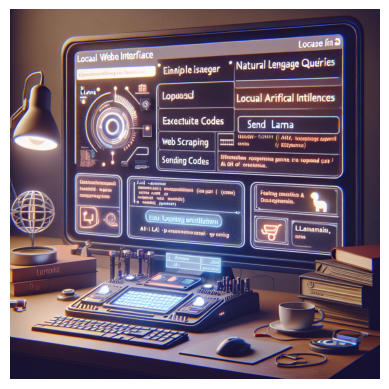

In [32]:
chain_four.invoke({"article": article})